# Product Range Analysis
## III. Product Categorization



## Table of Contents

- [Project Overview](#overview)
- [Product Categorization](#categorization)

<a id='overview'></a>
## Overview

You are given a sales transactions history data of an online store that sells household goods. Perform product range and customer segmentation analysis to help the stakeholders identify the top performing products, categories, and customers. 


### Business Problem
Based on the sales transactions data:
1. Identify the top performers: top customer, top product, and top category
2. Identify the customer segments based on RFM
3. Did higher-priced products contribute to higher sales than the lower-priced products?
4. Were sales higher during Christmas season (December) as compared to other months?


### Datasets and Attributes

The original dataset contains **541909** transaction records from **2018-11-29 to 2019-12-07**. It has 7 attributes:

- **InvoiceNo**: Invoice reference number uniquely assigned for each transaction. If the InvoiceNo starts with 'C', it indicates a cancellation
- **StockCode**: Product or item code uniquely assigned to each distinct product
- **Description**: Product or item name
- **Quantity**: The quantities for each product or item per transaction
- **InvoiceDate**: Invoice date and time, the day and time the transaction was generated by the system
- **UnitPrice**: Product price per unit
- **CustomerID**: Customer reference number uniquely assigned to each customer


### Project Scope
1. Data Preprocessing 
2. Exploratory Data Analysis
3. Customer Segmentation based on RFM Metrics (using percentile ranking and K-means clustering)
4. Product Categorization & Product Category Analysis
5. Statistical Hypotheses
6. Insights
7. Dashboard

<a id='categorization'></a>
### Product Category Identification
Product categorization is important as the quality of product analysis depends heavily on the ability to accurately group or cluster similar products. Product categorization can enhance customer experience, aid in advertising campaigns, and improve operational efficiency.

- Product categories will be based on the ``Description`` column.
- Text processing - perform lowercasing of all the words and removing of stop words. Lemmatization is not necessary as the words in the ``Description`` column don't need to be in their root words or stem words. 
- Clustering - K-means elbow method will be used to identify the number of clusters and to cluster the texts.
- WordCloud to identify the most important/common words in each cluster

In [3]:
# Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the dataset

sales_df = pd.read_pickle("C:/Users/offic/OneDrive/Desktop/product data analysis/sales_df.pkl")
sales_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,LineTotal,Date,Period,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850,15.30,2018-11-29,2018-11,Thursday,8
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850,22.00,2018-11-29,2018-11,Thursday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8


In [6]:
# Create copy of the dataframe

sales_category = sales_df.copy()

In [7]:
# Check the number of unique values in the Description column

sales_category['Description'].nunique()

4199

In [8]:
sales_category.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'LineTotal', 'Date', 'Period', 'Day',
       'Hour'],
      dtype='object')

In [9]:
# Convert Description in lower case and store in Text column

sales_category['Text'] = sales_category['Description'].str.lower()

cols = ['InvoiceNo', 'StockCode', 'Description', 'Text', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'LineTotal', 'Date', 'Period', 'Day',
       'Hour']

sales_category = sales_category[cols]
sales_category.head()

,InvoiceNo,StockCode,Description,Text,Quantity,InvoiceDate,UnitPrice,CustomerID,LineTotal,Date,Period,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850,15.30,2018-11-29,2018-11,Thursday,8
1,536365,71053,WHITE METAL LANTERN,white metal lantern,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850,22.00,2018-11-29,2018-11,Thursday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8


#### Remove stopwords

- Stopwords are common words that carry little semantic meaning and are often excluded during text analysis (Examples are 'the', 'a', 'is', etc.). NLTK has a list of stopwords in 16 different languages. 

In [12]:
# Remove stop words

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

sales_category['Text'] = sales_category['Text'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\offic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


#### Create tf-idf vectors for Text column

- TF-IDF stands for ***term-frequency - inverse document frequency***. It is a commonly used natural language processing model that helps you determine the most important words in each document in the corpus. 
- The idea behind tf-idf is that each corpus might have more shared words than just stopwords. These common words are like stopwords and should be removed or at least down-weighted in importance. 
- For example, if I am an astronomer, ‘sky’ might be used often but is not important, so I want to downweight that word. TF-Idf does precisely that. It will take texts that share common language and ensure the most common words across the entire corpus don't show up as keywords. 
- Tf-idf helps keep the document-specific frequent words weighted high and the common words across the entire corpus weighted low.

In [13]:
# Create tf-idf vectors for Text column
# Initialize a TFidfVectorizer object

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

#transform Text
X = tfidf_vectorizer.fit_transform(sales_category['Text'])

#### Fit KMeans and calculate sum of squared distances for each k

In [14]:
# Fit KMeans and calculate sum of squared distances for each k

ssd = {}
for k in range(1, 11):
    
    #initialize Kmeans with k clusters and fit it
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    
    # assign sum of squared distance to k element of the sse dictionary
    ssd[k] = km.inertia_ # sum of squared distances to closest cluster center

#### Plot sum of squared distances for each k

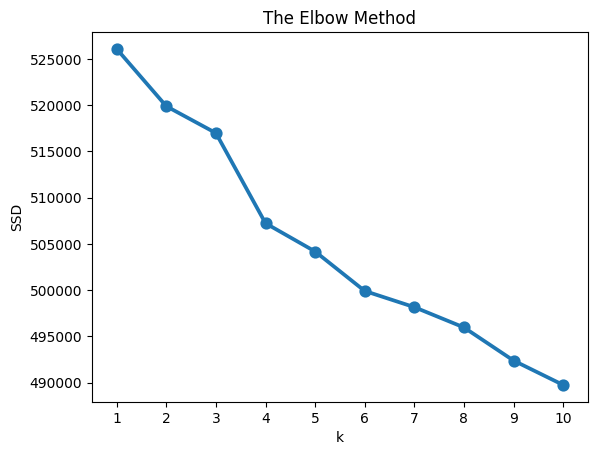

In [15]:
# Plot SSD for each k

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSD')
sns.pointplot(x=list(ssd.keys()), y=list(ssd.values()))
plt.show();

-  The largest angles are identified at points 7 and 9

#### Run K-means using 7 clusters

In [16]:
kmeans7 = KMeans(n_clusters=7, random_state=1)

#fit k-means clustering on the normalized dataset
model7 = kmeans7.fit(X)

#extract cluster labels
cluster_labels_7 = model7.labels_

# create Cluster7 column in the cat_df
sales_category = sales_category.assign(Cluster7=cluster_labels_7)

#### Run K-means using 9 clusters

In [17]:
# run KMeans using 9 clusters
kmeans9 = KMeans(n_clusters=9, random_state=1)

#fit k-means clustering on the normalized dataset
model9 = kmeans9.fit(X)

#extract cluster labels
cluster_labels_9 = model9.labels_

# create Cluster9 column in the cat_df
sales_category = sales_category.assign(Cluster9=cluster_labels_9)

In [19]:
sales_category[['Description', 'Text', 'Cluster7', 'Cluster9']]

,Description,Text,Cluster7,Cluster9
0,WHITE HANGING HEART T-LIGHT HOLDER,white hanging heart t-light holder,0,7
1,WHITE METAL LANTERN,white metal lantern,3,7
2,CREAM CUPID HEARTS COAT HANGER,cream cupid hearts coat hanger,3,1
3,KNITTED UNION FLAG HOT WATER BOTTLE,knitted union flag hot water bottle,3,1
4,RED WOOLLY HOTTIE WHITE HEART.,red woolly hottie white heart.,0,7
...,...,...,...,...
541904,PACK OF 20 SPACEBOY NAPKINS,pack 20 spaceboy napkins,3,1
541905,CHILDREN'S APRON DOLLY GIRL,children's apron dolly girl,3,1
541906,CHILDRENS CUTLERY DOLLY GIRL,childrens cutlery dolly girl,3,1
541907,CHILDRENS CUTLERY CIRCUS PARADE,childrens cutlery circus parade,3,1


#### Get the most occuring words in the Text column for each cluster in Cluster7 using wordcloud

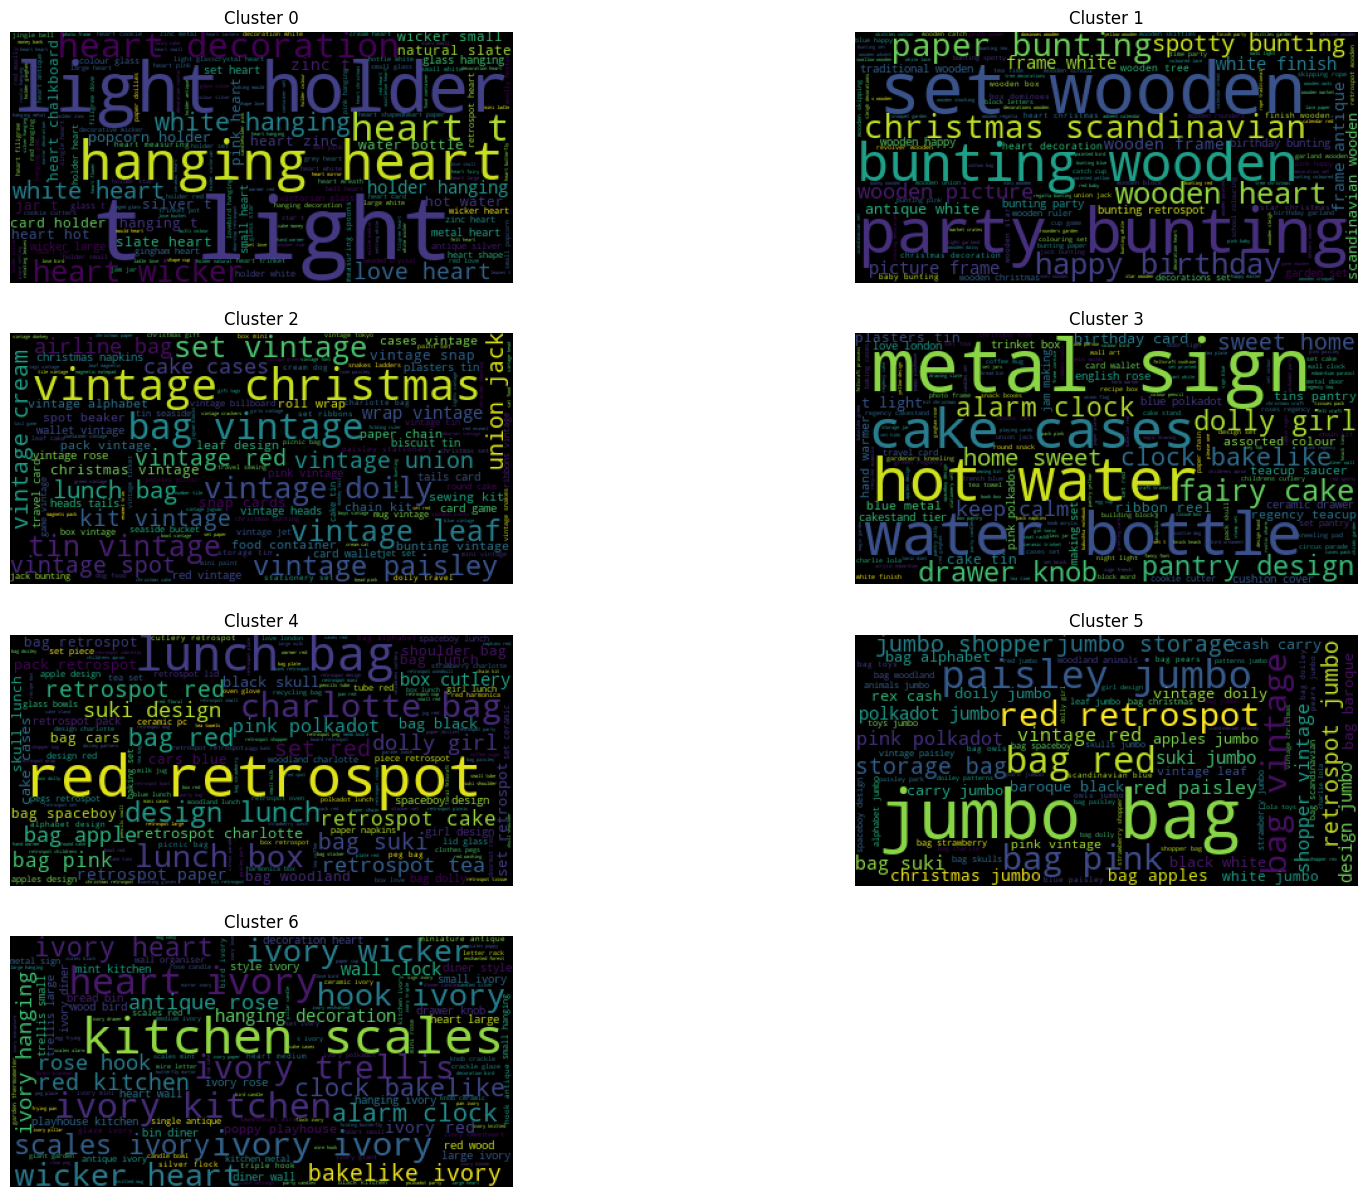

In [21]:
# Get the most occuring words in the Text for each cluster in Cluster7 using wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 15])
for c in range(len(sales_category['Cluster7'].unique())):
    ax = fig.add_subplot(4, 2, c + 1)
    ax.set_title(f'Cluster {c}')
    cluster = sales_category[sales_category['Cluster7'] == c]
    wordcloud = WordCloud(max_words=1000, margin=0).generate(' '.join(cluster['Text']))
    ax.imshow(wordcloud)
    ax.axis('off')

plt.show()


#### Get the most occuring words in the Text column for each cluster in Cluster9

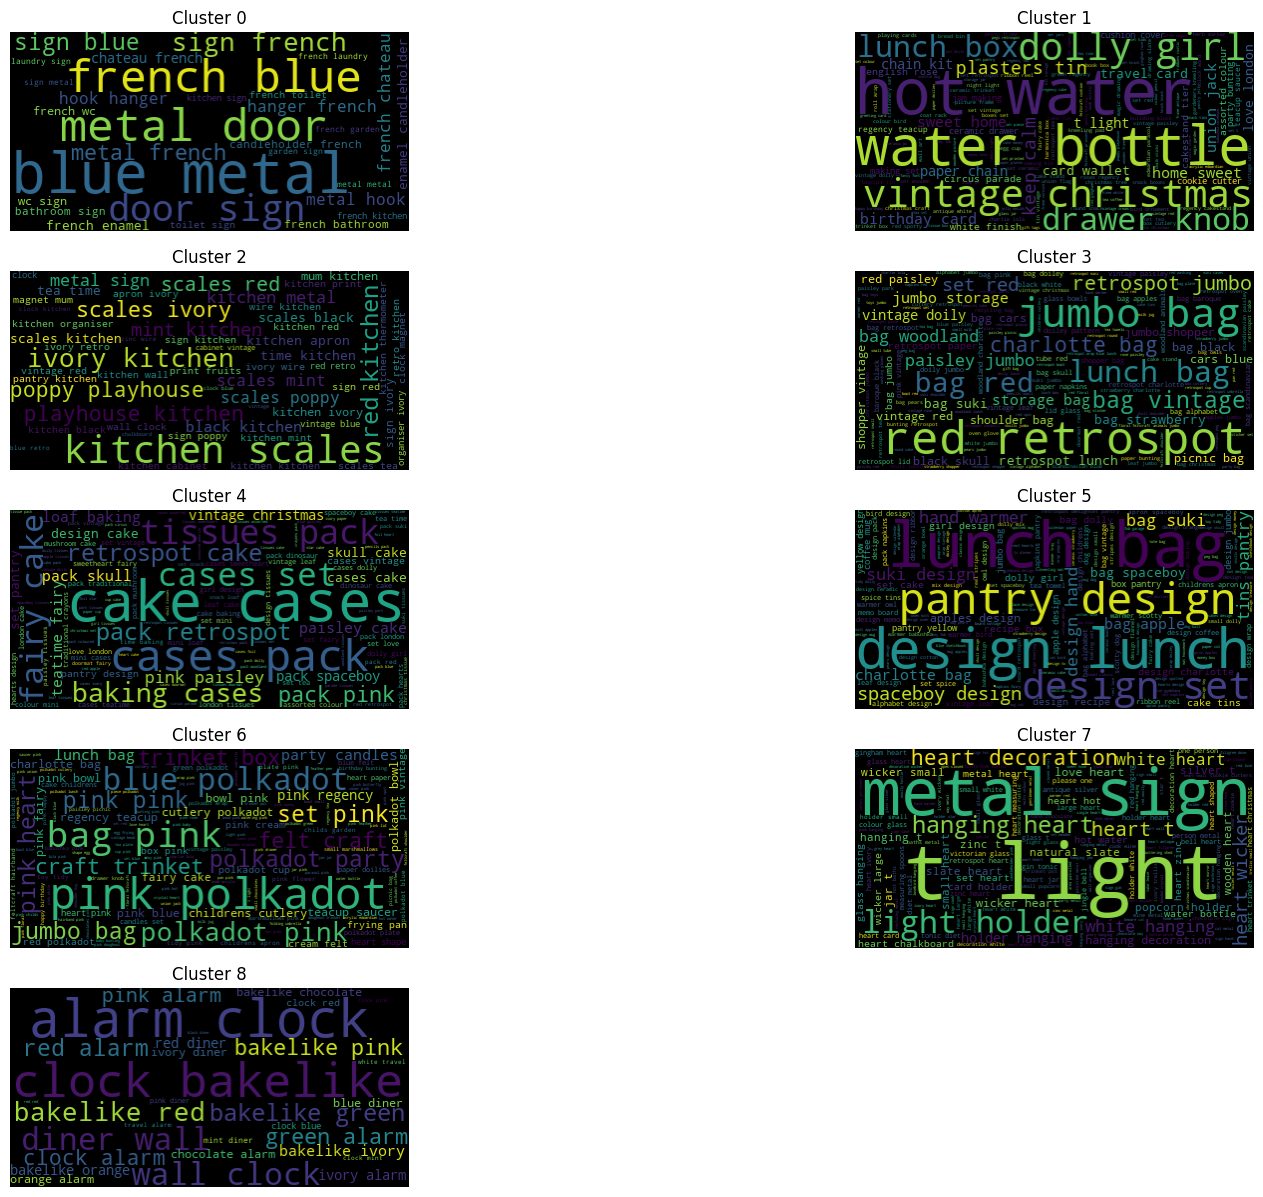

In [22]:
# Get the most occuring words in the Text for each cluster in Cluster9

fig = plt.figure(figsize=[20, 15])
for c in range (len(sales_category['Cluster9'].unique())):
    ax = fig.add_subplot(5, 2, c+1)
    ax.set_title('Cluster %d'%c)
    cluster = sales_category[sales_category['Cluster9'] == c]
    wordcloud = WordCloud(max_words=1000, margin=0).generate(' '.join(cluster['Text']))
    ax.imshow(wordcloud)
    ax.axis('off')

#### Based on wordcloud outputs, the 7-cluster solution is more appropriate to use
- Cluster 0 - Wicker items
- Cluster 1 - Bags
- Cluster 2 - Drawer knobs
- Cluster 3 - Tea light holders
- Cluster 4 - Kitchen and pantry items
- Cluster 5 - Food and beverage carriers
- Cluster 6 - Arts, crafts, and gifts

#### Create category based on cluster 7

In [23]:
def create_category(df):
    """pass a dataframe and return category based on clusters"""
    if df['Cluster7'] == 0:
        return 'Wicker items'
    elif df['Cluster7'] == 1:
        return 'Bags'
    elif df['Cluster7'] == 2:
        return 'Drawer knobs'
    elif df['Cluster7'] == 3:
        return 'Tea light holders'
    elif df['Cluster7'] == 4:
        return 'Kitchen and pantry items'
    elif df['Cluster7'] == 5:
        return 'Food and beverage carriers'
    else:
        return 'Arts, crafts, and gifts'
    
# apply function to sales_category and create a variable Category
sales_category['Category'] = sales_category.apply(create_category, axis = 1)

In [24]:
sales_category.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Text', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerID', 'LineTotal', 'Date', 'Period',
       'Day', 'Hour', 'Cluster7', 'Cluster9', 'Category'],
      dtype='object')

In [25]:
cols = ['InvoiceNo', 'StockCode', 'Description', 'Category', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerID', 'LineTotal', 'Date', 'Period',
       'Day', 'Hour']

sales_category = sales_category[cols]

In [26]:
sales_category.head()

,InvoiceNo,StockCode,Description,Category,Quantity,InvoiceDate,UnitPrice,CustomerID,LineTotal,Date,Period,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,Wicker items,6,2018-11-29 08:26:00,2.55,17850,15.30,2018-11-29,2018-11,Thursday,8
1,536365,71053,WHITE METAL LANTERN,Tea light holders,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,Tea light holders,8,2018-11-29 08:26:00,2.75,17850,22.00,2018-11-29,2018-11,Thursday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,Tea light holders,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,Wicker items,6,2018-11-29 08:26:00,3.39,17850,20.34,2018-11-29,2018-11,Thursday,8


#### Load the sales_category dataframe as a .pkl and csv files to local folder

In [28]:
sales_category.to_pickle("C:/Users/offic/OneDrive/Desktop/product data analysis/sales_category.pkl")

In [29]:
sales_category.to_csv('C:/Users/offic/OneDrive/Desktop/product data analysis/sales_category', index=False)